In [1]:
# Basic dependencies and variables
import sys, os
act_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
if act_root not in sys.path:
    sys.path.insert(0, act_root)

import torch
import numpy as np
import yaml
from pathlib import Path

from act.front_end.vnnlib_loader.create_specs import VNNLibSpecCreator
from act.front_end.model_synthesis import synthesize_models_from_specs

# CIFAR-100 class names (100 fine-grained classes)
CIFAR100_CLASSES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

print("LOADING CIFAR-100 VNNLIB BENCHMARK")

# 1. Load VNNLib instance, only take one (can be adjusted)
creator = VNNLibSpecCreator(config_name="vnnlib_default")
spec_results = creator.create_specs_for_data_model_pairs(
    categories=["cifar100_2024"], max_instances=1, validate_shapes=True
)
print(f"✓ Loaded {len(spec_results)} instance(s)")

selected_instance = spec_results[0:1]
wrapped_models, reports = synthesize_models_from_specs(selected_instance)
combo_id, wrapped_model = list(wrapped_models.items())[0]

# 2. Extract basic data such as input and label
input_layer = wrapped_model[0]         # InputLayer
labeled_input = input_layer.labeled_input
input_spec_layer = wrapped_model[1]    # InputSpecLayer
input_spec = input_spec_layer.spec
epsilon = float((input_spec.ub - input_spec.lb).max())
output_spec_layer = wrapped_model[-1]  # OutputSpecLayer
output_spec = output_spec_layer.spec
true_label = labeled_input.label
input_tensor = labeled_input.tensor.detach().clone()

print(f"Instance: {combo_id}")
print(f"  True label: {true_label} ({CIFAR100_CLASSES[true_label]})")
print(f"  Epsilon: {epsilon:.6f}")

# 3. Build wrapped model
class WrappedNet(torch.nn.Module):
    def __init__(self, wrapped_model):
        super().__init__()
        self.wrapped_model = wrapped_model
    def forward(self, x):
        # Skip input and input spec layers
        layers = self.wrapped_model[2:] if "InputLayer" in type(self.wrapped_model[0]).__name__ else self.wrapped_model
        for l in layers:
            x = l(x)
        return x

model = WrappedNet(wrapped_model)
model.eval()

# 4. Use PGD to generate counterexample (untargeted)
import torch.nn.functional as F

def _to_like_tensor(v, like: torch.Tensor):
    if v is None:
        return None
    if torch.is_tensor(v):
        return v.to(device=like.device, dtype=like.dtype)
    return torch.as_tensor(v, device=like.device, dtype=like.dtype)

def mutate(
    x: torch.Tensor,
    model: torch.nn.Module,
    y: int,
    *,
    eps: float | None = None,
    lb=None,
    ub=None,
    steps: int = 40,
    step_size: float | None = None,
    random_start: bool = True,
):
    """PGD attack: maximize CE loss to flip prediction.

    - If lb/ub are provided, we treat them as the feasible box and project into it.
    - Otherwise, we use an L_inf ball around x with radius eps.
    """
    x0 = x.detach()

    lb_t = _to_like_tensor(lb, x0)
    ub_t = _to_like_tensor(ub, x0)

    if lb_t is not None and ub_t is not None:
        x_low, x_high = lb_t, ub_t
    else:
        if eps is None:
            raise ValueError("eps must be provided when lb/ub are not available")
        x_low, x_high = x0 - float(eps), x0 + float(eps)

    # default step size: spread movement across the available range
    if step_size is None:
        step_size = float((x_high - x_low).abs().max()) / max(int(steps), 1)
        step_size = max(step_size, 1e-6)

    # random start inside the feasible set
    if random_start:
        x_adv = x_low + torch.rand_like(x0) * (x_high - x_low)
    else:
        x_adv = x0.clone()

    # make sure we start in-bounds
    x_adv = torch.max(torch.min(x_adv, x_high), x_low).detach()

    for _ in range(int(steps)):
        x_adv.requires_grad_(True)
        logits = model(x_adv)
        if isinstance(logits, tuple):
            logits = logits[0]
        if logits.dim() == 1:
            logits = logits.unsqueeze(0)

        y_t = torch.full((logits.shape[0],), int(y), dtype=torch.long, device=logits.device)
        loss = F.cross_entropy(logits, y_t)

        grad = torch.autograd.grad(loss, x_adv, only_inputs=True)[0]

        # gradient ascent on loss
        x_adv = (x_adv + float(step_size) * grad.sign()).detach()

        # project back to feasible set
        x_adv = torch.max(torch.min(x_adv, x_high), x_low).detach()

    return x_adv

# 5. Multi-start PGD and check for counterexample
lb = input_spec.lb if hasattr(input_spec, 'lb') else None
ub = input_spec.ub if hasattr(input_spec, 'ub') else None

found_ce = None
for i in range(50):  # restarts
    candidate = mutate(
        input_tensor,
        model=model,
        y=true_label,
        eps=epsilon,
        lb=lb,
        ub=ub,
        steps=40,
        random_start=True,
    )

    with torch.no_grad():
        logits = model(candidate)
        if isinstance(logits, tuple):
            logits = logits[0]
        if logits.dim() == 1:
            logits = logits.unsqueeze(0)
        pred = logits.argmax(dim=1).item()

    if pred != true_label:
        found_ce = candidate
        print(
            f"Found counterexample at restart {i}: pred={pred} ({CIFAR100_CLASSES[pred]}) != "
            f"true={true_label} ({CIFAR100_CLASSES[true_label]})"
        )
        break

if found_ce is not None:
    print("Counterexample found!")
else:
    print("No counterexample found.")



[ACT] Auto-detecting project root: /data1/guanqin/newACT/ACT
[WARN] Gurobi license not found at: /data1/guanqin/newACT/ACT/modules/gurobi/gurobi.lic
[INFO] Please ensure gurobi.lic is placed in: /data1/guanqin/newACT/ACT/modules/gurobi
LOADING CIFAR-100 VNNLIB BENCHMARK


onnxsim not available, skipping simplification


✓ Loaded 1 instance(s)

🧬 Synthesizing models from 1 spec result(s)...
✓ cifar100_2024 + CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_116_sidx_8002_eps_0.0039: Created 1 wrapped model(s)

🎉 Synthesized 1 wrapped models from specs!
Instance: m:CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_116_sidx_8002_eps_0.0039|x:cifar100_2024|s:0|is:BOX|os:RANGE_m0.0
  True label: 85 (tank)
  Epsilon: 0.030590
Found counterexample at restart 0: pred=89 (tractor) != true=85 (tank)
Counterexample found!


original: shape=(3, 32, 32) min=-1.8678 max=1.9824 mean=-0.1634 std=0.7523 finite%=100.0%
original: display_mode=as_is display_std=0.3406
mutated: shape=(3, 32, 32) min=-1.8824 max=1.9966 mean=-0.1628 std=0.7519 finite%=100.0%
mutated: display_mode=as_is display_std=0.3403


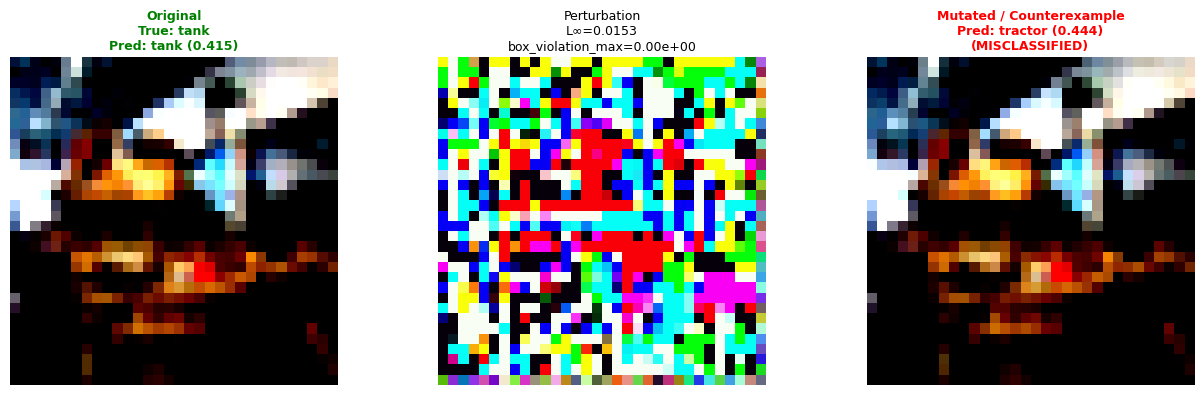

In [2]:
# Visualize original vs mutated (counterexample) image (like vnnlib_fuzzer)
import matplotlib.pyplot as plt
import numpy as np
import torch

# Common CIFAR-100 normalization (torchvision convention)
_CIFAR100_MEAN = torch.tensor([0.5071, 0.4867, 0.4408], dtype=torch.float32)
_CIFAR100_STD = torch.tensor([0.2675, 0.2565, 0.2761], dtype=torch.float32)


def _tensor_stats(x: torch.Tensor, name: str):
    x = x.detach().float().cpu()
    if x.dim() == 4:
        x = x.squeeze(0)
    finite = torch.isfinite(x)
    finite_ratio = float(finite.float().mean().item())
    x_f = x[finite] if finite.any() else x.reshape(-1)
    if x_f.numel() == 0:
        print(f"{name}: shape={tuple(x.shape)} all-nonfinite")
        return
    print(
        f"{name}: shape={tuple(x.shape)} min={float(x_f.min().item()):.4f} max={float(x_f.max().item()):.4f} "
        f"mean={float(x_f.mean().item()):.4f} std={float(x_f.std().item()):.4f} finite%={finite_ratio*100:.1f}%"
    )


def _minmax01(chw: torch.Tensor) -> torch.Tensor:
    vmin = float(chw.min().item())
    vmax = float(chw.max().item())
    denom = (vmax - vmin) if (vmax - vmin) > 1e-8 else 1.0
    return (chw - vmin) / denom


def _to_hwc01(img, *, name: str = "img"):
    """Convert CHW/BCHW tensor (or numpy) to HWC float in [0,1] for plt.imshow.

    Tries multiple decoding strategies and picks the one with highest contrast (std).
    Also prints debug stats so we can see why things look black.
    """
    if not torch.is_tensor(img):
        arr = np.asarray(img).astype(np.float32, copy=False)
        if arr.max() > 1.5:
            arr = arr / 255.0
        else:
            vmin = float(arr.min())
            vmax = float(arr.max())
            if vmin < 0.0 or vmax > 1.0:
                denom = (vmax - vmin) if (vmax - vmin) > 1e-8 else 1.0
                arr = (arr - vmin) / denom
        arr = np.clip(arr, 0.0, 1.0)
        return arr

    t = img.detach().float().cpu()
    if t.dim() == 4:
        t = t.squeeze(0)

    _tensor_stats(t, name)

    # Ensure CHW if possible
    chw = t
    if chw.dim() == 3 and chw.shape[0] not in (1, 3) and chw.shape[-1] in (1, 3):
        # HWC -> CHW
        chw = chw.permute(2, 0, 1)

    candidates = []

    if chw.dim() == 3 and chw.shape[0] == 3:
        vmin = float(chw.min().item())
        vmax = float(chw.max().item())

        # 1) assume [0,255]
        if vmax > 1.5:
            candidates.append(("/255", (chw / 255.0).clamp(0, 1)))

        # 2) assume already [0,1]
        candidates.append(("as_is", chw.clamp(0, 1)))

        # 3) CIFAR100 de-norm
        mean = _CIFAR100_MEAN.view(3, 1, 1)
        std = _CIFAR100_STD.view(3, 1, 1)
        candidates.append(("cifar_denorm", (chw * std + mean).clamp(0, 1)))

        # 4) [-1,1] -> [0,1]
        candidates.append(("(-1,1)->(0,1)", ((chw + 1.0) / 2.0).clamp(0, 1)))

        # 5) min-max
        candidates.append(("minmax", _minmax01(chw).clamp(0, 1)))

        # Pick most contrasty (avoid all-black)
        best_name, best = None, None
        best_score = -1.0
        for nm, cand in candidates:
            cand_f = cand[torch.isfinite(cand)]
            score = float(cand_f.std().item()) if cand_f.numel() else -1.0
            if score > best_score:
                best_score = score
                best_name, best = nm, cand

        print(f"{name}: display_mode={best_name} display_std={best_score:.4f}")
        hwc = best.permute(1, 2, 0).numpy()
        return np.clip(hwc, 0.0, 1.0)

    # Non-3ch fallback
    arr = chw.numpy().astype(np.float32, copy=False)
    vmin = float(np.nanmin(arr))
    vmax = float(np.nanmax(arr))
    if vmax > 1.5:
        arr = arr / 255.0
    elif vmin < 0.0 or vmax > 1.0:
        denom = (vmax - vmin) if (vmax - vmin) > 1e-8 else 1.0
        arr = (arr - vmin) / denom

    if arr.ndim == 3 and arr.shape[0] in (1, 3):
        arr = np.transpose(arr, (1, 2, 0))
    elif arr.ndim == 2:
        arr = arr[..., None]

    arr = np.clip(arr, 0.0, 1.0)
    return arr


def _ensure_bchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 3:
        return x.unsqueeze(0)
    return x


def _get_pred_conf(x: torch.Tensor):
    xb = _ensure_bchw(x)
    with torch.no_grad():
        logits = model(xb)
        if isinstance(logits, dict):
            logits = logits.get('output', logits)
        if isinstance(logits, tuple):
            logits = logits[0]
        if logits.dim() == 1:
            logits = logits.unsqueeze(0)
        probs = torch.softmax(logits[0], dim=0)
        pred = int(probs.argmax().item())
        conf = float(probs[pred].item())
    return pred, conf


def _as_chw(x: torch.Tensor) -> torch.Tensor:
    t = x.detach()
    if t.dim() == 4:
        t = t.squeeze(0)
    return t


if found_ce is None:
    print("No counterexample to visualize: found_ce is None")
else:
    x0 = input_tensor
    x1 = found_ce

    # Predictions / confidence
    orig_pred, orig_conf = _get_pred_conf(x0)
    mut_pred, mut_conf = _get_pred_conf(x1)

    # Perturbation
    d = (x1.detach() - x0.detach())
    linf = float(d.abs().max().item())

    # If we have box bounds, check feasibility (should be within lb/ub)
    in_box_msg = None
    if 'lb' in globals() and 'ub' in globals() and lb is not None and ub is not None:
        lb_t = _as_chw(lb).to(device=x1.device, dtype=x1.dtype)
        ub_t = _as_chw(ub).to(device=x1.device, dtype=x1.dtype)
        x1_chw = _as_chw(x1)
        low_violation = float((lb_t - x1_chw).clamp(min=0).max().item())
        high_violation = float((x1_chw - ub_t).clamp(min=0).max().item())
        max_violation = max(low_violation, high_violation)
        in_box_msg = f"box_violation_max={max_violation:.2e}"

    # Difference visualization (normalize to 0..1 for display)
    d0 = _as_chw(d).float().cpu()
    if d0.dim() == 3 and d0.shape[0] in (1, 3):
        d0 = d0.permute(1, 2, 0)
    d_np = d0.numpy()
    d_vis = (d_np - d_np.min()) / (d_np.max() - d_np.min() + 1e-8)

    # Images (also prints debug stats)
    x0_np = _to_hwc01(x0, name="original")
    x1_np = _to_hwc01(x1, name="mutated")

    fig, axes = plt.subplots(1, 3, figsize=(13, 4))

    axes[0].imshow(x0_np, interpolation="nearest")
    axes[0].set_title(
        f"Original\nTrue: {CIFAR100_CLASSES[true_label]}\nPred: {CIFAR100_CLASSES[orig_pred]} ({orig_conf:.3f})",
        fontsize=9,
        color='green' if orig_pred == true_label else 'red',
        fontweight='bold',
    )
    axes[0].axis("off")

    axes[1].imshow(d_vis, interpolation="nearest")
    title_mid = f"Perturbation\nL∞={linf:.4f}"
    if in_box_msg is not None:
        title_mid += f"\n{in_box_msg}"
    axes[1].set_title(title_mid, fontsize=9)
    axes[1].axis("off")

    status = "MISCLASSIFIED" if mut_pred != true_label else "still correct"
    axes[2].imshow(x1_np, interpolation="nearest")
    axes[2].set_title(
        f"Mutated / Counterexample\nPred: {CIFAR100_CLASSES[mut_pred]} ({mut_conf:.3f})\n({status})",
        fontsize=9,
        color='red' if mut_pred != true_label else 'green',
        fontweight='bold',
    )
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
